In [86]:
from __future__ import print_function
import argparse
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#Check model structure
from torchsummary import summary
from tqdm import *



In [87]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def visual_earlystopping(train_loss, valid_loss):
    " Visualizing the Loss and the Early Stopping Checkpoint "
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
    
    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
#    fig.savefig('loss_plot.png', bbox_inches='tight')


In [88]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        len_ = 52
        hidden_layer = 64 # 갯수 수정 필요 아마 128
        self.fc1 = nn.Linear(len_, hidden_layer)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_layer)

        self.fc21 = nn.Linear(hidden_layer, hidden_layer*2)
        self.fc22 = nn.Linear(hidden_layer, hidden_layer*2)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_layer*2)

        self.fc_code = nn.Linear(hidden_layer*2, hidden_layer*2)

        self.fc3 = nn.Linear(hidden_layer*2, hidden_layer)
        self.bn3 = nn.BatchNorm1d(num_features=hidden_layer)
        
        self.fc4 = nn.Linear(hidden_layer, len_)
        self.bn4 = nn.BatchNorm1d(num_features=len_)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h1 = self.fc1(x)
        h1 = self.bn1(h1) # batchnormalization: h1
        h1 = F.relu(h1)

        h21 = self.fc21(h1)
        h21 = self.bn2(h21) # batchnormalization: h21(optional)

        h22 = self.fc22(h1)
        h22 = self.bn2(h22) # batchnormalization: h22(optional)
        return h21, h22

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) #std 내에서 정수를 균등하게 생성
        return mu + eps*std

# Latent_coded의 act.fn 수정 필요
    def latent_coded(self, z):
        h_coded = torch.sigmoid(self.fc_code(z)) # F.sigmoid(self.fc_code(z))
        return h_coded

    def decode(self, z):
        h3 = self.fc3(z)
        h3 = self.bn3(h3)
        h3 = F.relu(h3)
        # torch.div(h3 - h3.mean(axis=1).view(-1,1).repeat(1, h3.shape[1]), h3.std(axis=1).view(-1,1).repeat(1, h3.shape[1])) # batch norm.
        h4 = self.fc4(h3)
        h4 = self.bn4(h4)
        h4 = torch.sigmoid(h4)
        return h4

    def forward(self, x):
        len_ = 52
        #len_ = 64
#       hidden_layer = 200
        mu, logvar = self.encode(x.view(-1, len_))
        z = self.reparameterize(mu, logvar)
        z = self.latent_coded(z)
        z_coded = (z > 0.5).int().float()
        return self.decode(z_coded), z_coded, mu, logvar, z
#        return self.decode(z), z, mu, logvar

# Loss function의 BCE to MSE or 추가 term 필요
# VAE Loss function의 첫번째 term이 BCE가 맞는지

def loss_function(recon_x, x, mu, logvar, z, z_coded):
    len_ = 52
    #len_ = 64

    recon_x = recon_x.double()
    x = x.double()

    #Loss term1: BCE to RMSE
    RMSE = torch.sqrt(torch.mean((recon_x-x)**2)) 
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, len_), reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # MSE = torch.mean(torch.mean((z - z_coded).pow(2),axis=1))
    MAE = torch.mean(torch.mean((z - z_coded).abs(), axis=1))
    return RMSE + KLD + MAE

def train(epoch):
    model.train()
    batch_idx = 0

    train_loss = 0
    vaild_loss = 0

    avg_train_losses = []
    avg_valid_losses = []    
    train_losses = []
    valid_losses = []
    # initialize the early_stopping object
    #early stopping
    patiences = 100
    deltas = 0.00001 
    early_stopping = EarlyStopping(patience=patiences, verbose=True, delta=deltas)

    for batch_idx, sample_data in enumerate(train_loader):
        data = sample_data[0]
        data_noisy = sample_data[1]

        data = data.to(device)
        data_noisy = data_noisy.to(device)
        optimizer.zero_grad()
        recon_batch, z_coded, mu, logvar, z = model(data_noisy.float())
        loss = loss_function(recon_batch, data, mu, logvar, z, z_coded)
        loss.backward()
        train_loss += loss.item()
        train_losses.append(train_loss)

        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item()))
            
    model.eval()            
    for batch_idx, sample_data in enumerate(valid_loader):
        data = sample_data[0]
        data_noisy = sample_data[1]
        data = data.to(device)
        data_noisy = data_noisy.to(device)

        recon_batch, z_coded, mu, logvar, z = model(data_noisy.float())
        loss += loss_function(recon_batch, data, mu, logvar, z, z_coded)
        vaild_loss += loss.item()
        valid_losses.append(vaild_loss)

        early_stopping(vaild_loss, model)
        if early_stopping.early_stop:
            print("Earlystopping")
            break
                
        if batch_idx % args.log_interval == 0:
            print('valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(valid_loader.dataset),
                       100. * batch_idx / len(valid_loader),
                       loss.item()))
    path_checkpoint = 'checkpoint.pt'
    model.load_state_dict(torch.load(path_checkpoint))

    return (model, z_coded, train_losses, valid_losses)

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, z_coded, mu, logvar, z = model(data.float())
            test_loss += loss_function(recon_batch, data, mu, logvar, z, z_coded).item()
    test_loss /= (i+1)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return (z_coded)

In [89]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch-size', type=int, default=200, metavar='N',
                        help='input batch size for training (default: 128)')
    parser.add_argument('--epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='enables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument("--mode", default='client')
    parser.add_argument("--port", default=52162)
    parser.add_argument('--learning_rate', type=float, default=1e-1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('-f')
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    def normalize_convert(CSI_data1):
        max_v1 = np.max(CSI_data1)
        min_v1 = np.min(CSI_data1)
        CSI_data1 = (CSI_data1 - min_v1) / (max_v1 - min_v1)
        return (CSI_data1)


    def mean_data(CSI_data1, CSI_data2):
        CSI_mean1 = (CSI_data1 + CSI_data2) / 2
        return (CSI_mean1)
    # Load data
    # path1 = F"/content/gdrive/My Drive/USRP_data/sanitized_phase_1.csv"
    # path2 = F"/content/gdrive/My Drive/USRP_data/sanitized_phase_2.csv"
    path1 = '../data/sanitized_phase/sanitized_phase_1.csv'
    path2 = '../data/sanitized_phase/sanitized_phase_2.csv'
    path3 = '../data/sanitized_phase/sanitized_phase_3.csv'
    path4 = '../data/sanitized_phase/sanitized_phase_4.csv'
    CSI_data1 = pd.read_csv(path1, header=None)
    CSI_data2 = pd.read_csv(path2, header=None)
    CSI_data3 = pd.read_csv(path3, header=None)
    CSI_data4 = pd.read_csv(path4, header=None)

In [90]:
    # for i in range(CSI_data2.shape[1]):
    #     plt.plot(CSI_data2.values[:,i])
    # plt.show()

Train Epoch: 1 [0/5120 (0%)]	Loss: 1.280201
Train Epoch: 1 [2000/5120 (38%)]	Loss: 0.170732
Train Epoch: 1 [4000/5120 (77%)]	Loss: 0.173199
Validation loss decreased (inf --> 0.345932).  Saving model ...
valid Epoch: 1 [0/1280 (0%)]	Loss: 0.345932
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 3 out of 100
EarlyStopping counter: 4 out of 100
EarlyStopping counter: 5 out of 100
EarlyStopping counter: 6 out of 100
====> Test set loss: 0.2091
Train Epoch: 2 [0/5120 (0%)]	Loss: 0.149400
Train Epoch: 2 [2000/5120 (38%)]	Loss: 0.175847
Train Epoch: 2 [4000/5120 (77%)]	Loss: 0.161825
Validation loss decreased (inf --> 0.305825).  Saving model ...
valid Epoch: 2 [0/1280 (0%)]	Loss: 0.305825
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 3 out of 100
EarlyStopping counter: 4 out of 100
EarlyStopping counter: 5 out of 100
EarlyStopping counter: 6 out of 100
====> Test set loss: 0.1805
Train Epoch: 3 [

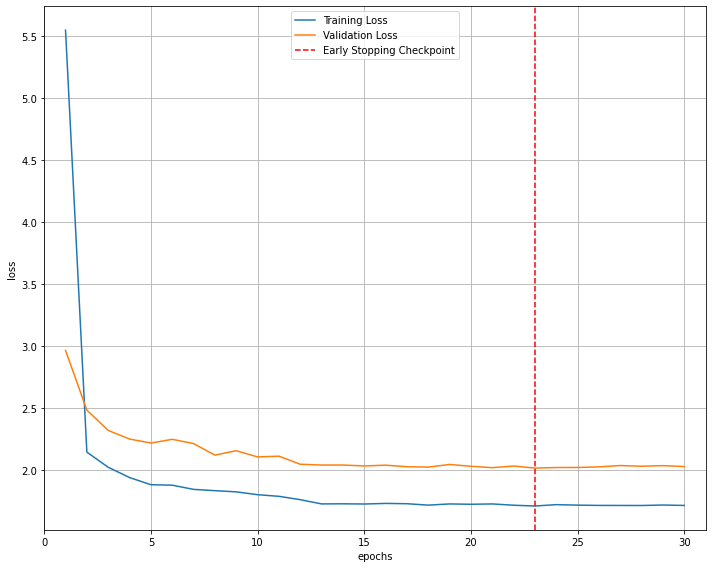

In [91]:
    # Transpose
    CSI_data1 = CSI_data1.values.T
    CSI_data2 = CSI_data2.values.T
    CSI_data3 = CSI_data3.values.T
    CSI_data4 = CSI_data4.values.T

    # Normalization, generating Mean_data
    CSI_data1 = normalize_convert(CSI_data1)
    CSI_data2 = normalize_convert(CSI_data2)
    CSI_data3 = normalize_convert(CSI_data3)
    CSI_data4 = normalize_convert(CSI_data4)

    from sklearn import model_selection
    CSI_data1_tr1, CSI_data1_te = model_selection.train_test_split(CSI_data1, test_size=0.2, shuffle=None)
    CSI_data2_tr1, CSI_data2_te = model_selection.train_test_split(CSI_data2, test_size=0.2, shuffle=None)
    CSI_data3_tr1, CSI_data3_te = model_selection.train_test_split(CSI_data3, test_size=0.2, shuffle=None)
    CSI_data4_tr1, CSI_data4_te = model_selection.train_test_split(CSI_data4, test_size=0.2, shuffle=None)

    CSI_data1_tr, CSI_data1_val = model_selection.train_test_split(CSI_data1_tr1, test_size=0.2, shuffle=None)
    CSI_data2_tr, CSI_data2_val = model_selection.train_test_split(CSI_data2_tr1, test_size=0.2, shuffle=None)
    CSI_data3_tr, CSI_data3_val = model_selection.train_test_split(CSI_data3_tr1, test_size=0.2, shuffle=None)
    CSI_data4_tr, CSI_data4_val = model_selection.train_test_split(CSI_data4_tr1, test_size=0.2, shuffle=None)

    CSI_mean1_tr = mean_data(CSI_data1_tr, CSI_data2_tr)
    CSI_mean1_val = mean_data(CSI_data1_val, CSI_data2_val)
    CSI_mean1_te = mean_data(CSI_data1_te, CSI_data2_te)

    CSI_mean2_tr = mean_data(CSI_data3_tr, CSI_data4_tr)
    CSI_mean2_val = mean_data(CSI_data3_val, CSI_data4_val)
    CSI_mean2_te = mean_data(CSI_data3_te, CSI_data4_te)

    # %%
    # x_train_noisy = np.concatenate([CSI_data1_tr, CSI_data2_tr, CSI_data3_tr, CSI_data4_tr], axis=0)
    # x_train = np.concatenate([CSI_mean1_tr, CSI_mean1_tr, CSI_mean2_tr, CSI_mean2_tr], axis=0)
    # x_valid_noisy = np.concatenate([CSI_data1_val, CSI_data2_val, CSI_data3_val, CSI_data4_val], axis=0)
    # x_valid = np.concatenate([CSI_mean1_val, CSI_mean1_val, CSI_mean2_val, CSI_mean2_val], axis=0)
    # x_test = np.concatenate([CSI_data1_te, CSI_data2_te, CSI_data3_te, CSI_data4_te], axis=0)

    x_train_noisy = np.concatenate([CSI_data1_tr, CSI_data2_tr, CSI_data3_tr, CSI_data4_tr], axis=0)
    x_train = np.concatenate([CSI_mean1_tr, CSI_mean1_tr, CSI_mean2_tr, CSI_mean2_tr], axis=0)
    x_valid_noisy = np.concatenate([CSI_data1_val, CSI_data2_val, CSI_data3_val, CSI_data4_val], axis=0)
    x_valid = np.concatenate([CSI_mean1_val, CSI_mean1_val, CSI_mean2_val, CSI_mean2_val], axis=0)
    x_test = np.concatenate([CSI_data1_te, CSI_data2_te, CSI_data3_te, CSI_data4_te], axis=0)


    # x_train1, x_valid = model_selection.train_test_split(input_data, test_size=0.2, shuffle=None)
    # x_train_noisy1, x_valid_noisy = model_selection.train_test_split(input_data_noisy, tet_size=0.2, shuffle=None)

    # %%
    train_set = torch.tensor(x_train)
    train_noisy_set = torch.tensor(x_train_noisy)
    valid_set = torch.tensor(x_valid)
    valid_noisy_set = torch.tensor(x_valid_noisy)
    test_set = torch.tensor(x_test)

    from torch.utils.data import TensorDataset
    train_data = TensorDataset(train_set, train_noisy_set)
    valid_data = TensorDataset(valid_set, valid_noisy_set)

    import torch
    import numpy as np
    from torch.utils.data import DataLoader

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    train_loader = DataLoader(dataset=train_data,
                              batch_size=args.batch_size,
                              shuffle=True,
                              **kwargs)
    valid_loader = DataLoader(dataset=valid_data,
                              batch_size=args.batch_size,
                              shuffle=True,
                              **kwargs)
    test_loader = DataLoader(dataset=test_set,
                             batch_size=args.batch_size,
                             shuffle=True,
                             **kwargs)
    
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    #summary(model, (64, 1600))

    list_train = []
    list_test = []
    list_train_loss = []
    list_valid_loss = []
    for epoch in range(1, args.epochs + 1):
        #train
        model, a, train_loss, valid_loss = train(epoch)
        list_train_loss.append(np.mean(train_loss))
        list_valid_loss.append(np.mean(valid_loss))
        #test
        b = test(epoch)
        scheduler.step(epoch - 1)

    list_train.append(a)
    list_test.append(b)
    visual_earlystopping(list_train_loss, list_valid_loss)
# model save
# path_model = F"/content/gdrive/My Drive/USRP_data/model_save.pth"
# torch.save(model.state_dict(), path_model)

tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
      

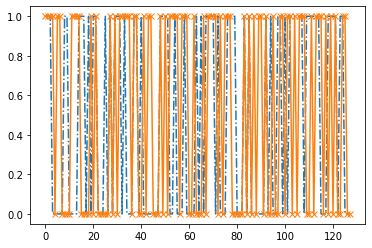

In [92]:
train_result = list_train[0].cpu().detach().numpy()
test_result = list_test[0].cpu().detach().numpy()

print(list_train[0][1])
print(list_train[0][2])
print(list_train[0][1]==list_train[0][2])
# #trian_result
plt.plot(train_result[1],'-.')
plt.plot(train_result[2],'-x')
plt.show()

In [93]:
# train_result = list_train[0].cpu().detach().numpy()
# test_result = list_test[0].cpu().detach().numpy()
#
# #trian_result
# #plt.plot(train_result[0],'-.')
# #plt.plot(train_result[1],'-x')
#
# #test_result
# plt.plot(test_result[0],'-.')
# plt.plot(test_result[1],'-x')
# plt.show()
#

In [94]:
# print(torch.sum(list_train[0][1,:] == list_train[0][0,:]))
#

In [95]:
# import seaborn as sns
# acc = (test_result[0] == test_result).mean(axis=1)
# sns.boxplot(acc)
# plt.show()
#

In [97]:
def hamming_distance(x, y):
    # bin_x = format(x, "032b")
    # bin_y = format(y, "032b")
    len_bit = max(len(x), len(y))
    bin_x = x
    bin_y = y

    result = 0
    for i in range(len_bit):
        if bin_x[i] != bin_y[i]:
            result += 1
    return result

train_result_hamming = hamming_distance(train_result[0], train_result[1])
test_result_hamming = hamming_distance(test_result[0], test_result[1])

print("Hamming distance of train:", train_result_hamming)
print("Hamming distance of test:",test_result_hamming)

Hamming distance of train: 79
Hamming distance of test: 62
